### Import Libraries

In [1]:
# Check ipynb file is in the correct location
%pwd

'C:\\Users\\c1032379\\OneDrive - Newcastle University\\10_Research_Project\\Project_MRes\\notebooks'

In [2]:
import os
import ee
import geemap
import geemap.chart as chart
from geemap import cartoee
import pandas as pd
import numpy as np
import datetime
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import ipygee as ui
from skimage.filters import threshold_otsu
from skimage.filters import threshold_li
from skimage.filters import threshold_local
from collections import namedtuple
import time

import warnings
warnings.filterwarnings('ignore')

### Get map of Addis Ababa

In [3]:
# Get basemap layer and set it to Addis Ababa
map = geemap.Map(center=(8.9801, 38.7805), zoom=11)
map

Map(center=[8.9801, 38.7805], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=HBox(chil…

In [4]:
# Get Addis boundary shapefile from https://data.humdata.org/dataset/cod-ab-eth
addis_shpfile = "C:/Users/c1032379/OneDrive - Newcastle University/10_Research_Project/Project_MRes/data/input_data/admin_boundaries/addis_bndry_py_hdx_2021.shp"
addis_bndry = geemap.shp_to_ee(addis_shpfile)
map.addLayer(addis_bndry, {}, 'Addis Boundary')

### Pre-process and filter data

In [5]:
# Set area of interest covering Addis Ababa
aoi = ee.Geometry.Point([38.7805, 8.9801])

# Data required
LS_8 = "LANDSAT/LC08/C02/T1_L2"
LS_7 = "LANDSAT/LE07/C02/T1_L2"
LS_5 = "LANDSAT/LT05/C02/T1_L2"

# # Set date filters
start = ee.Date('1991-01-01')
date_today = datetime.date.today().strftime('%Y-%m-%d')
end = ee.Date(date_today)

# Set additional filters 
cloud = ee.Filter.lt("CLOUD_COVER", 5)
season = ee.Filter.calendarRange(10, 2, 'month')
order = "system:time_start"

# Filter the collection
def filter_cltn(cltn, aoi, cloud, startDate, endDate, season, order):
    return ee.ImageCollection(cltn)\
    .filterBounds(aoi)\
    .filter(cloud)\
    .filterDate(startDate, endDate)\
    .filter(season)\
    .sort(order)\
    .map(lambda image: image.clip(addis_bndry))

In [6]:
# Code obtained from a combination of 
# https://github.com/giswqs/geemap/blob/ca365d23a10dbbbb29ff3ff5cd29acc89f42d10f/geemap/timelapse.py#L2075
# and https://gist.github.com/jdbcode/76b9ac49faf51627ebd3ff988e10adbc

### Function to mask out clouds and apply scaling factors
def fmask(image):
    qaMask = image.select('QA_PIXEL').bitwiseAnd(int('11111', 2)).eq(0)
    
    # Apply the scaling factors to the appropriate bands.
    opticalBands = image.select('SR_B.').multiply(0.0000275).add(-0.2)
    thermalBands = image.select('ST_B.*').multiply(0.00341802).add(149.0)    

    # Replace the original bands with the scaled ones and apply the masks.
    return image.addBands(opticalBands, None, True).addBands(thermalBands, None, True).updateMask(qaMask)


### Function to rename Landsat 5 and 7 bands. 
def Bands_L5_L7(L5_L7imgs):
    return L5_L7imgs.select(
        ["SR_B1", "SR_B2", "SR_B3", "SR_B4", "SR_B5", "SR_B7"],
        ["Blue", "Green", "Red", "NIR", "SWIR1", "SWIR2"],
    )


### Function to rename Landsat 8 bands. 
def Bands_L8(L8imgs):
    return L8imgs.select(
        ["SR_B2", "SR_B3", "SR_B4", "SR_B5", "SR_B6", "SR_B7"],
        ["Blue", "Green", "Red", "NIR", "SWIR1", "SWIR2"],
    )

### Functions to prepare and resample Landsat 5, 7 and 8 imagery.
def prepL8(img):
    orig = img
    img = fmask(img)
    img = Bands_L8(img)
    return ee.Image(img.copyProperties(orig, orig.propertyNames())).resample("bicubic")

def prep_L5L7(img):
    orig = img
    img = fmask(img)
    img = Bands_L5_L7(img)
    return ee.Image(img.copyProperties(orig, orig.propertyNames())).resample("bicubic")

### Visualise and inspect Landsat 5, 7 and 8 data between 1991 and 2021

In [7]:
# Set visual parameters
vis_params = {"min": 0, "max": 0.4,  "gamma": 1.2, "bands": ["NIR", "SWIR1", "SWIR2"]}

# Landsat 8 - Run functions with date filters and pre-processing methods
Landsat_8 = filter_cltn(LS_8, aoi, cloud, start, end, season, order).map(prepL8)
map.addLayer(Landsat_8, vis_params, "Landsat 8")

# Landsat 7 - Run functions with date filters, pre-processing methods and gap filling information
Landsat_7 = filter_cltn(LS_7, aoi, cloud, start, end, season, order).map(prep_L5L7)
map.addLayer(Landsat_7, vis_params, "Landsat 7")

# Landsat 5 - Run functions with date filters and pre-processing methods
Landsat_5 = filter_cltn(LS_5, aoi, cloud, start, end, season, order).map(prep_L5L7)
map.addLayer(Landsat_5, vis_params, "Landsat 5")

In [8]:
# number of images in the collection. 
print(f"Landsat 8 = {Landsat_8.size().getInfo()} images, Landsat 7 = {Landsat_7.size().getInfo()} images, Landsat 5 = {Landsat_5.size().getInfo()} images, Total = {Landsat_5.size().getInfo() + Landsat_7.size().getInfo() + Landsat_8.size().getInfo()}")

Landsat 8 = 36 images, Landsat 7 = 80 images, Landsat 5 = 43 images, Total = 159


In [9]:
# get the dates and times each image was obtained in the collection

def cltn_dates(cltn):
    return geemap.image_dates(cltn, date_format='YYYY-MM-dd HH:mm').getInfo()

l8_dates = cltn_dates(Landsat_8)
l7_dates = cltn_dates(Landsat_7)
l5_dates = cltn_dates(Landsat_5)

dates = pd.DataFrame({"Landsat 8": pd.Series(l8_dates), "Landsat 7": pd.Series(l7_dates), "Landsat 5": pd.Series(l5_dates)})

with pd.option_context('display.max_rows', None):
    display(dates)

,Landsat 8,Landsat 7,Landsat 5
0,2013-12-01 07:42,1999-12-03 07:33,1991-01-19 07:00
1,2014-01-18 07:41,2000-02-05 07:33,1991-02-04 07:00
2,2014-12-04 07:40,2000-12-05 07:30,1991-11-03 07:04
3,2014-12-20 07:40,2002-01-25 07:29,1991-11-19 07:04
4,2015-01-05 07:40,2002-02-26 07:29,1992-02-23 07:04
5,2015-02-06 07:40,2003-01-12 07:28,1992-11-21 07:01
6,2015-11-21 07:40,2003-12-14 07:29,1993-11-08 07:02
7,2015-12-23 07:40,2004-12-16 07:29,1993-11-24 07:02
8,2016-01-08 07:40,2005-01-01 07:29,1994-01-11 07:01
9,2016-01-24 07:40,2005-02-02 07:29,1994-01-27 07:01


In [10]:
# Get the properties of the first image to see image data

def first_image(img):
    first = img.first()
    first_props = geemap.image_props(first).getInfo()
    return first_props

l8_image = first_image(Landsat_8)
l7_image = first_image(Landsat_7)
l5_image = first_image(Landsat_5)

props_dict = dict(A = (l8_image), B = (l7_image), c = (l5_image))
image_props = pd.DataFrame(dict([ (k,pd.Series(v)) for k,v in props_dict.items() ]))

with pd.option_context('display.max_rows', None):
    display(image_props)

,A,B,c
ALGORITHM_SOURCE_SURFACE_REFLECTANCE,LaSRC_1.5.0,LEDAPS_3.4.0,LEDAPS_3.4.0
ALGORITHM_SOURCE_SURFACE_TEMPERATURE,st_1.3.0,st_1.3.0,st_1.3.0
CLOUD_COVER,0.01,0,0
CLOUD_COVER_LAND,0.01,0,0
COLLECTION_CATEGORY,T1,T1,T1
COLLECTION_NUMBER,2,2,2
CORRECTION_BIAS_BAND_1,NaN,INTERNAL_CALIBRATION,CPF
CORRECTION_BIAS_BAND_2,NaN,INTERNAL_CALIBRATION,CPF
CORRECTION_BIAS_BAND_3,NaN,INTERNAL_CALIBRATION,CPF
CORRECTION_BIAS_BAND_4,NaN,INTERNAL_CALIBRATION,CPF


In [11]:
i = Landsat_8.first()
i.bandNames().getInfo()
i.select('Blue').projection().getInfo()

{'type': 'Projection',
 'crs': 'EPSG:32637',
 'transform': [30, 0, 412485, 0, -30, 1074915]}

### Add indices

In [12]:
# Include the following indices - Normalized difference built-up index (NDBI), 
# Normalized Difference Thermal Index (NDTI) and Buildup Index (BUI)

def indices(img):
    
    # calculate ndbi
    ndbi = img.normalizedDifference(["SWIR1", "NIR"]).rename('NDBI')
    
    # calculate mndbi
    mndbi = img.normalizedDifference(["SWIR2", "Blue"]).rename('MNDBI')
    
    
    buiA = img.expression("(SWIR1 - NIR) / (SWIR1 + NIR)", {
        "SWIR1": img.select("SWIR1"),
        "NIR": img.select("NIR")
    }).rename("BUI_A")
    
    buiB = img.expression("(NIR - Red) / (NIR + Red)", {
        "NIR": img.select("NIR"),
        "Red": img.select("Red")
    }).rename("BUI_B")
        
    bui_AB = buiA.addBands(buiB);
    bui = bui_AB.normalizedDifference(["BUI_A", "BUI_B"]).rename("BUI")
    
    #Calculate Index-Based Built-Up Index (IBI)
    # https://bikeshbade.com.np/tutorials/Detail/?title=Most%20used%20spectral%20Indices%20with%20free%20satellite%20data&code=23
    ibiA = img.expression('2 * SWIR1 / (SWIR1 + NIR)', {
        'SWIR1': img.select('SWIR1'),
        'NIR'  : img.select('NIR')}).rename("IBI_A")
    
    ibiB = img.expression('(NIR / (NIR + Red)) + (Green / (Green + SWIR1))', {
        "NIR"  : img.select("NIR"),
        "Red"  : img.select("Red"),
        "Green": img.select("Green"),
        "SWIR1": img.select("SWIR1")}).rename("IBI_B")
    
    ibiAB = ibiA.addBands(ibiB);
    ibi = ibiAB.normalizedDifference(["IBI_A", "IBI_B"]).rename("IBI")
    
    
    # Calculate ENDISI - https://docs.dea.ga.gov.au/notebooks/Real_world_examples/Urban_change_detection.html
    swir_diff = img.expression("SWIR1 / SWIR2", {"SWIR1": img.select("SWIR1"), "SWIR2": img.select("SWIR2"),
                                                }).rename('swir_diff')
    
     
    mndwi = img.normalizedDifference(["Green", "SWIR1"]).rename('MNDWI')
 
    img = img.addBands([swir_diff, mndwi])
    
    blue_mean = img.select("Blue").reduceRegion(ee.Reducer.mean(), addis_bndry, 30).toImage().rename("blue_mean")
    
    swir_mean = img.select("swir_diff").reduceRegion(ee.Reducer.mean(), addis_bndry, 30).toImage().rename("swir_mean")
    
    mndwi_mean = img.select("MNDWI").multiply(img.select("MNDWI")).reduceRegion(ee.Reducer.mean(), addis_bndry, 30).toImage().rename("mndwi_mean")
    
    img = img.addBands([blue_mean, swir_mean, mndwi_mean])
    
    alpha = img.expression('(2 * b("blue_mean")) / (b("swir_mean") +  b("mndwi_mean"))').rename("alpha")
    
    img = img.addBands(alpha)
    
    ENDISI = img.expression('(b("Blue") - b("alpha") * (b("swir_diff") + b("MNDWI")**2)) / (b("Blue") + b("alpha") * (b("swir_diff") + b("MNDWI")**2))').rename("ENDISI")
    
    # PISI
    
    pisi = img.expression('(0.8192 * b("Blue") - 0.5735 * b("NIR") + 0.0750)').rename("PISI")
    
    return  img.addBands([ndbi, mndbi, bui, ibi, ENDISI, pisi])

### Merge collection and get annual sequence

In [13]:
### Adapted code from https://gist.github.com/jdbcode/76b9ac49faf51627ebd3ff988e10adbc

# Setup vars to get dates.
startYear = 1991
endYear = 2021
startMonth = 10
startDay = 1
nDays = 151

# Get annual median collection.    
def getAnnualComp(y):
    startDate = ee.Date.fromYMD(
    ee.Number(y), ee.Number(startMonth), ee.Number(startDay))
    endDate = startDate.advance(ee.Number(nDays), 'day')

    # Filter collections and prepare them for merging.
    t_LC08coly = filter_cltn(LS_8, aoi, cloud, startDate, endDate, season, order).map(prepL8)
    t_LE07coly = filter_cltn(LS_7, aoi, cloud, startDate, endDate, season, order).map(prep_L5L7)
    t_LT05coly = filter_cltn(LS_5, aoi, cloud, startDate, endDate, season, order).map(prep_L5L7)

    # Merge the collections.
    col = t_LC08coly.merge(t_LE07coly).merge(t_LT05coly)
    
    yearImg = col.median()
    nBands = yearImg.bandNames().size()
    yearImg = ee.Image(ee.Algorithms.If(
        nBands,
        yearImg,
        dummyImg))
    return(indices(yearImg)
           .set({'year': y, 'system:time_start': startDate.millis(), 'nBands': nBands}))

# # Make a dummy image for missing years.
bandNames = ee.List(['Blue', 'Green', 'Red', 'NIR', 'SWIR1', 'SWIR2'])
fillerValues = ee.List.repeat(0, bandNames.size())
dummyImg = ee.Image.constant(fillerValues).rename(bandNames).selfMask().int16()

# Get a list of years
years = ee.List.sequence(startYear, endYear)

# Make list of annual image composites.
imgList = years.map(getAnnualComp)

# Convert image composite list to collection
imgCol = ee.ImageCollection.fromImages(imgList)

# check the first image in the collection
first_collated = imgCol.first()
first_collated.getInfo()

{'type': 'Image',
 'bands': [{'id': 'Blue',
   'data_type': {'type': 'PixelType',
    'precision': 'double',
    'min': -0.2,
    'max': 1.6022125},
   'crs': 'EPSG:4326',
   'crs_transform': [1, 0, 0, 0, 1, 0]},
  {'id': 'Green',
   'data_type': {'type': 'PixelType',
    'precision': 'double',
    'min': -0.2,
    'max': 1.6022125},
   'crs': 'EPSG:4326',
   'crs_transform': [1, 0, 0, 0, 1, 0]},
  {'id': 'Red',
   'data_type': {'type': 'PixelType',
    'precision': 'double',
    'min': -0.2,
    'max': 1.6022125},
   'crs': 'EPSG:4326',
   'crs_transform': [1, 0, 0, 0, 1, 0]},
  {'id': 'NIR',
   'data_type': {'type': 'PixelType',
    'precision': 'double',
    'min': -0.2,
    'max': 1.6022125},
   'crs': 'EPSG:4326',
   'crs_transform': [1, 0, 0, 0, 1, 0]},
  {'id': 'SWIR1',
   'data_type': {'type': 'PixelType',
    'precision': 'double',
    'min': -0.2,
    'max': 1.6022125},
   'crs': 'EPSG:4326',
   'crs_transform': [1, 0, 0, 0, 1, 0]},
  {'id': 'SWIR2',
   'data_type': {'type': 

### Inspect annual data

In [14]:
dates = imgCol.aggregate_array('system:time_start').map(lambda d: ee.Date(d).format('YYYY-MM-dd'))
landsat_dates = dates.getInfo()
print(landsat_dates)

['1991-10-01', '1992-10-01', '1993-10-01', '1994-10-01', '1995-10-01', '1996-10-01', '1997-10-01', '1998-10-01', '1999-10-01', '2000-10-01', '2001-10-01', '2002-10-01', '2003-10-01', '2004-10-01', '2005-10-01', '2006-10-01', '2007-10-01', '2008-10-01', '2009-10-01', '2010-10-01', '2011-10-01', '2012-10-01', '2013-10-01', '2014-10-01', '2015-10-01', '2016-10-01', '2017-10-01', '2018-10-01', '2019-10-01', '2020-10-01', '2021-10-01']


In [15]:
# Just ensure that all the bands are in each image
print(first_collated.bandNames().getInfo())

['Blue', 'Green', 'Red', 'NIR', 'SWIR1', 'SWIR2', 'swir_diff', 'MNDWI', 'blue_mean', 'swir_mean', 'mndwi_mean', 'alpha', 'NDBI', 'MNDBI', 'BUI', 'IBI', 'ENDISI', 'PISI']


In [16]:
size = imgCol.size().getInfo()
size

31

In [17]:
# Just make sure info for each year is there
for i in range(0, size):
    Im = ee.Image(imgList.get(i)).select(["ENDISI"])
    print(Im.getInfo())

{'type': 'Image', 'bands': [{'id': 'ENDISI', 'data_type': {'type': 'PixelType', 'precision': 'double'}, 'crs': 'EPSG:4326', 'crs_transform': [1, 0, 0, 0, 1, 0]}], 'properties': {'system:time_start': 686275200000, 'nBands': 6, 'year': 1991}}
{'type': 'Image', 'bands': [{'id': 'ENDISI', 'data_type': {'type': 'PixelType', 'precision': 'double'}, 'crs': 'EPSG:4326', 'crs_transform': [1, 0, 0, 0, 1, 0]}], 'properties': {'system:time_start': 717897600000, 'nBands': 6, 'year': 1992}}
{'type': 'Image', 'bands': [{'id': 'ENDISI', 'data_type': {'type': 'PixelType', 'precision': 'double'}, 'crs': 'EPSG:4326', 'crs_transform': [1, 0, 0, 0, 1, 0]}], 'properties': {'system:time_start': 749433600000, 'nBands': 6, 'year': 1993}}
{'type': 'Image', 'bands': [{'id': 'ENDISI', 'data_type': {'type': 'PixelType', 'precision': 'double'}, 'crs': 'EPSG:4326', 'crs_transform': [1, 0, 0, 0, 1, 0]}], 'properties': {'system:time_start': 780969600000, 'nBands': 6, 'year': 1994}}
{'type': 'Image', 'bands': [{'id': '

In [18]:
# Plot band data 
# https://github.com/fitoprincipe/ipygee/blob/master/examples/Chart.ipynb

chart_ts = ui.chart.Image.series(**{
    'imageCollection': imgCol, 
    'region': addis_bndry,
    'reducer': 'median',
    'scale': 30,
    'bands': ["NDBI", "MNDBI", "IBI", "ENDISI", "PISI"],
    'title': "Annual urban index band median",
    'x_title': "Year",
    'y_title': "Normalised Index Value"
})

chart_ts.renderWidget()

HTML(value='<embed src=data:image/svg+xml;charset=utf-8;base64,PD94bWwgdmVyc2lvbj0nMS4wJyBlbmNvZGluZz0ndXRmLTg…

In [19]:
# Can also get the values in a dataframe
df = chart_ts.dataframe

In [20]:
df["year"] = chart_ts.dataframe.index.year

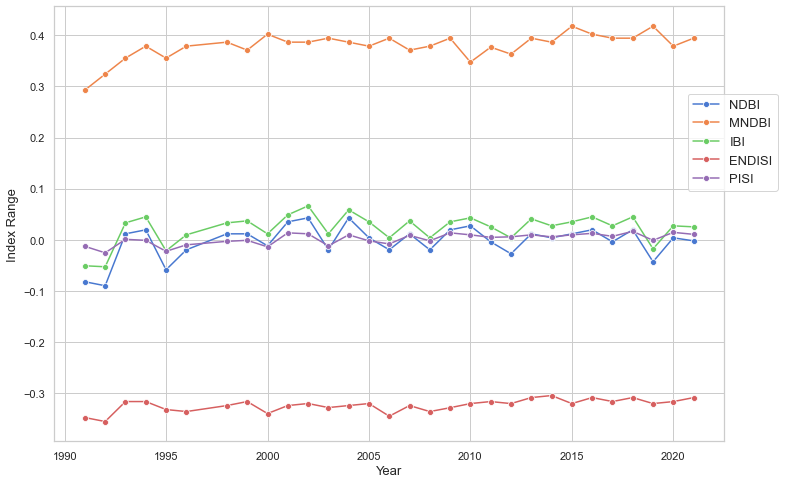

In [21]:
plt.figure(figsize=(12, 8))
plt.tight_layout()
sns.set(style="whitegrid", palette="muted", color_codes=True) 
sns.lineplot(x="year", y="NDBI", data=df, marker='o')
sns.lineplot(x="year", y="MNDBI", data=df, marker='o')
sns.lineplot(x="year", y="IBI", data=df, marker='o')
sns.lineplot(x="year", y="ENDISI", data=df, marker='o')
sns.lineplot(x="year", y="PISI", data=df, marker='o')
plt.xlabel("Year", fontsize=13)
plt.ylabel("Index Range", fontsize=13)
legend_labels = ["NDBI","MNDBI", "IBI", "ENDISI", "PISI"]
plt.legend(labels=legend_labels, bbox_to_anchor=(1.09, 0.814), loc='upper right', ncol=1, fontsize=13)
plt.savefig('C:/Users/c1032379/OneDrive - Newcastle University/10_Research_Project/Project_MRes/graphs/index_median.png', dpi=300)

In [22]:
print(f"min: {df.min()}, max: {df.max()}")

min: NDBI        -0.089821
MNDBI        0.292987
IBI         -0.052709
ENDISI      -0.355463
PISI        -0.025405
year      1991.000000
dtype: float64, max: NDBI         0.042994
MNDBI        0.417969
IBI          0.066437
ENDISI      -0.304620
PISI         0.016608
year      2021.000000
dtype: float64


In [23]:
chart_ts = ui.chart.Image.series(**{
    'imageCollection': imgCol, 
    'region': addis_bndry,
    'reducer': ee.Reducer.variance(),
    'scale': 30,
    'bands': ["NDBI", "MNDBI", "IBI", "ENDISI", "PISI"],
    'title': "Annual urban index band variance",
    'x_title': "Year",
    'y_title': "Normalised Index Value"
})

chart_ts.renderWidget()

HTML(value='<embed src=data:image/svg+xml;charset=utf-8;base64,PD94bWwgdmVyc2lvbj0nMS4wJyBlbmNvZGluZz0ndXRmLTg…

In [24]:
# view NDBI side by side

# create names for map layers
layer_names = ['Index ' + str(year) for year in range(1991, 2022)]
# print(layer_names)

# set visuals
ndbi_vis = {"min": -1, "max": 1,  "bands": ["NDBI"], "palette": ["#1a9641", "#a6d96a", "#ffffbf", "#fdae61", "#d7191c"]}

# set up geemap map inspector
map_inspector_ndbi = geemap.Map(center=(8.9801, 38.7805), zoom=11)
map_inspector_ndbi.ts_inspector(
    left_ts=imgCol,
    right_ts=imgCol,
    left_names=layer_names,
    right_names=layer_names,
    left_vis=ndbi_vis,
    right_vis=ndbi_vis,
)
map_inspector_ndbi 

Map(center=[8.9801, 38.7805], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=Dropdown(…

In [25]:
# visual parameters 
urban_vis = {"min": -1, "max": 1, "bands": ["ENDISI"], "palette": ["fdf0d5", "780000", "669bbc"]}

# set up geemap map inspector
map_inspector_endisi = geemap.Map(center=(8.9801, 38.7805), zoom=11)
map_inspector_endisi.ts_inspector(
    left_ts=imgCol,
    right_ts=imgCol,
    left_names=layer_names,
    right_names=layer_names,
    left_vis=urban_vis,
    right_vis=urban_vis,
)
map_inspector_endisi

Map(center=[8.9801, 38.7805], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=Dropdown(…

In [26]:
# Inspect statistics for one year only 

# Get one annual image
y_1991 = ee.Image(imgList.get(0))

# obtain the statistics from that image 
def stats(img):
    y = img.select("NDBI", "MNDBI", "IBI", "ENDISI", "PISI")
    i = geemap.image_stats(y, addis_bndry, scale=30)
    return i.getInfo()

stats(y_1991)

{'max': {'ENDISI': 0.5445791222356885,
  'IBI': 0.6793646204894074,
  'MNDBI': 0.7772342776955316,
  'NDBI': 0.6281532202890914,
  'PISI': 0.14064852915355086},
 'mean': {'ENDISI': -0.32931419611490464,
  'IBI': -0.05998443347089949,
  'MNDBI': 0.2816289216629783,
  'NDBI': -0.09579283337631839,
  'PISI': -0.010442842114009306},
 'min': {'ENDISI': -0.6891885474537606,
  'IBI': -0.4987437847979442,
  'MNDBI': -0.41817050479244194,
  'NDBI': -0.5585669735248278,
  'PISI': -0.11806919473750029},
 'std': {'ENDISI': 0.12005257824946795,
  'IBI': 0.07250992080409381,
  'MNDBI': 0.09403786327814476,
  'NDBI': 0.08906808025801478,
  'PISI': 0.022690393970183406},
 'sum': {'ENDISI': -201143.25003891878,
  'IBI': -36638.215094699175,
  'MNDBI': 172017.35387223307,
  'NDBI': -58509.72468375572,
  'PISI': -6378.439762353875}}

### Get each year individually

In [27]:
y_1991 = ee.Image(imgList.get(0))
y_1992 = ee.Image(imgList.get(1))
y_1993 = ee.Image(imgList.get(2))
y_1994 = ee.Image(imgList.get(3))
y_1995 = ee.Image(imgList.get(4))
y_1996 = ee.Image(imgList.get(5))

y_1998 = ee.Image(imgList.get(7))
y_1999 = ee.Image(imgList.get(8))
y_2000 = ee.Image(imgList.get(9))
y_2001 = ee.Image(imgList.get(10))
y_2002 = ee.Image(imgList.get(11))
y_2003 = ee.Image(imgList.get(12))
y_2004 = ee.Image(imgList.get(13))
y_2005 = ee.Image(imgList.get(14))
y_2006 = ee.Image(imgList.get(15))
y_2007 = ee.Image(imgList.get(16))
y_2008 = ee.Image(imgList.get(17))
y_2009 = ee.Image(imgList.get(18))
y_2010 = ee.Image(imgList.get(19))
y_2011 = ee.Image(imgList.get(20))
y_2012 = ee.Image(imgList.get(21))
y_2013 = ee.Image(imgList.get(22))
y_2014 = ee.Image(imgList.get(23))
y_2015 = ee.Image(imgList.get(24))
y_2016 = ee.Image(imgList.get(25))
y_2017 = ee.Image(imgList.get(26))
y_2018 = ee.Image(imgList.get(27))
y_2019 = ee.Image(imgList.get(28))
y_2020 = ee.Image(imgList.get(29))
y_2021 = ee.Image(imgList.get(30)) 

annual_list = [y_1991, y_1992, y_1993, y_1994, y_1995, y_1996, y_1998, y_1999, y_2000, y_2001, y_2002, y_2003, y_2004, y_2005, 
               y_2006, y_2007, y_2008, y_2009, y_2010, y_2011, y_2012, y_2013, y_2014, y_2015, y_2016, y_2017, y_2018, y_2019,
              y_2020, y_2021]